In [1]:
import utils
import numpy as np

In [2]:
points2D = utils.read_points_2d('data/pts2d-pic_a.txt')
points3D = utils.read_points_3d('data/pts3d.txt')

In [3]:
img = utils.load_image('data/pic_a.jpg')
h = img.shape[0]
w = img.shape[1]

In [4]:
points2D

array([[880., 214.],
       [ 43., 203.],
       [270., 197.],
       [886., 347.],
       [745., 302.],
       [943., 128.],
       [476., 590.],
       [419., 214.],
       [317., 335.],
       [783., 521.],
       [235., 427.],
       [665., 429.],
       [655., 362.],
       [427., 333.],
       [412., 415.],
       [746., 351.],
       [434., 415.],
       [525., 234.],
       [716., 308.],
       [602., 187.]])

In [5]:
points3D

array([[312.747, 309.14 ,  30.086],
       [305.796, 311.649,  30.356],
       [307.694, 312.358,  30.418],
       [310.149, 307.186,  29.298],
       [311.937, 310.105,  29.216],
       [311.202, 307.572,  30.682],
       [307.106, 306.876,  28.66 ],
       [309.317, 312.49 ,  30.23 ],
       [307.435, 310.151,  29.318],
       [308.253, 306.3  ,  28.881],
       [306.65 , 309.301,  28.905],
       [308.069, 306.831,  29.189],
       [309.671, 308.834,  29.029],
       [308.255, 309.955,  29.267],
       [307.546, 308.613,  28.963],
       [311.036, 309.206,  28.913],
       [307.518, 308.175,  29.069],
       [309.95 , 311.262,  29.99 ],
       [312.16 , 310.772,  29.08 ],
       [311.988, 312.709,  30.514]])

$ x_i = x_{im} - o_x $


$ y_i = y_{im} - o_y $


Assuming insignificant radial distortion


$ x_i = f_x\frac{r_{11}X^w_i + r_{12}Y^w_i + r_{13}Z^w_i + T_x}{r_{31}X^w_i + r_{32}Y^w_i + r_{33}Z^w_i + T_z} $


$ y_i = f_y\frac{r_{21}X^w_i + r_{22}Y^w_i + r_{23}Z^w_i + T_y}{r_{31}X^w_i + r_{32}Y^w_i + r_{33}Z^w_i + T_z} $

$ \alpha = \frac{f_x}{f_y} = \frac{fs_y}{s_xf} = \frac{s_y}{s_x} $

$ x_ir_{21}X^w_i + x_ir_{22}Y^w_i + x_ir_{23}Z^w_i + x_iT_y =  y_iX^w_i\alpha r_{11} + y_iY^w_i\alpha r_{12} + y_iZ^w_i\alpha r_{13} + y_i\alpha T_x $



$ v_1 = r_{21},\quad v_2 = r_{22},\quad v_3 = r_{23},\quad v_4 = T_y $

$v_5 = \alpha r_{11},\quad v_6 = \alpha r_{12},\quad v_7 = \alpha r_{13},\quad v_8 = \alpha T_x$

In [6]:
def compute_v(points2D, points3D, ox, oy):
    assert points2D.shape[0] == points3D.shape[0]
    
    x = points2D[:, 0] - ox
    y = points2D[:, 1] - oy
    X = points3D[:, 0]    
    Y = points3D[:, 1]        
    Z = points3D[:, 2]
    
    xX = x*X
    xY = x*Y 
    xZ = x*Z
    yX = -y*X
    yY = -y*Y
    yZ = -y*Z
    
    A = np.column_stack((xX, xY, xZ, x, yX, yY, yZ, -y))
    assert A.shape[0] == points2D.shape[0]
    
    U, D, V = np.linalg.svd(A)
    
    return V.T[:, -1]

In [7]:
v = compute_v(points2D, points3D, w/2, h/2)

$ |\gamma| = \sqrt{v^2_1 + v^2_2 + v^2_3} $


$\text{If}\quad y_i(r_{21}X^i_w + r_{22}Y^i_w +r_{23}Z^i_w + T_y) < 0, \quad\text{change gamma's sign}$ 

In [8]:
def gamma_abs(v1, v2, v3):
    return np.sqrt(v1*v1 + v2*v2 + v3*v3)

def normalize_v(v, gamma, y, points3D, oy):
    vnorm = v / gamma
    Ty = vnorm[3]
    sig = (y[0] - oy) * (vnorm[0]*points3D[0][0] + vnorm[1]*points3D[0][1] + vnorm[2]*points3D[0][2] + vnorm[3])
    if sig > 0:
        return -vnorm
    return vnorm

$ \alpha = \frac{1}{|\gamma|}\sqrt{v^2_5 + v^2_6 + v^2_7} $ 

In [9]:
def alpha(gamma, v5, v6, v7):
    return np.sqrt(v5*v5 + v6*v6 + v7*v7) / gamma

$ v_1 = r_{21},\quad v_2 = r_{22},\quad v_3 = r_{23},\quad v_4 = T_y $

$v_5 = \alpha r_{11},\quad v_6 = \alpha r_{12},\quad v_7 = \alpha r_{13},\quad v_8 = \alpha T_x$

In [10]:
gamma_value = gamma_abs(v[0], v[1], v[2])
vnorm = normalize_v(v, gamma_value, points2D[:, 1], points3D, h/2)
alpha_value = alpha(gamma_value, v[4], v[5], v[6])
Tx = vnorm[7] / alpha_value
Ty = vnorm[3]

In [11]:
def compute_rotation(vnorm, alpha_value, ortho=False):
    r1 = vnorm[4:7] / alpha_value
    r2 = vnorm[0:3]
    r3 = np.cross(r1, r2)
    R = np.array([r1, r2, r3])
    return R

In [12]:
R = compute_rotation(vnorm, alpha_value)

$ Ax = b \quad A^TAx = A^Tb \quad x = (A^TA)^{-1} A^T b  $

In [13]:
def compute_tz_fx(points2D, points3D, R, Tx, ox):
    x = points2D[:, 0] - ox
    second_col = np.column_stack(
        (points3D, Tx * np.ones(points3D.shape[0]))
    ).dot(np.append(R[0, :], 1))
    A = np.column_stack((-x, second_col))
    b = x * points3D.dot(R[2, :])
    x = np.linalg.inv(A.T.dot(A)).dot(A.T.dot(b))
    return x[0], x[1]

In [14]:
Tz, fx = compute_tz_fx(points2D, points3D, R, Tx, w/2)   

$ \alpha = \frac{f_x}{f_y} = \frac{fs_y}{s_xf} = \frac{s_y}{s_x} $

In [15]:
fy = fx / alpha_value

In [17]:
def compute_KRT(R, Tx, Ty, Tz, fx, fy, ox, oy):
    RT = np.column_stack((R, np.array([Tx, Ty, Tz])))
    K = np.array([[fx, 0, ox], [0, fy, oy], [0, 0, 1]])
    return np.dot(K, RT)

In [18]:
KRT = compute_KRT(R, Tx, Ty, Tz, fx, fy, w/2, h/2)

In [19]:
def project(M, points_3d):
    n = len(points_3d)
    points_3d = np.concatenate((np.array(points_3d), np.ones((n, 1))), axis=1)
    points_3d_projected = np.dot(M, points_3d.T).T
    u, v = points_3d_projected[:, 0] / points_3d_projected[:, 2], points_3d_projected[:, 1] / points_3d_projected[:, 2]
    points_2d = np.hstack((u[:, np.newaxis], v[:, np.newaxis]))
    
    return points_2d

In [20]:
projected_points2D = project(KRT, points3D)

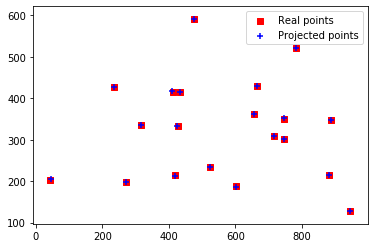

In [21]:
utils.visualize_points(points2D, projected_points2D)